In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p numpy,mlxtend,matplotlib,scikit-learn

Sebastian Raschka 
last updated: 2016-07-19 

CPython 3.5.1
IPython 5.0.0

numpy 1.11.0
mlxtend 0.4.2.dev0
matplotlib 1.5.1
scikit-learn 0.17.1


---

This Jupyter notebook contains the code to create the data visualizations for the article "Model evaluation, model selection, and algorithm selection in machine learning - Part II" at http://sebastianraschka.com/blog/2016/model-evaluation-selection-part2.html.

---

# Confidence Intervals via Holdout and K-fold

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Holdout method and binomial approximation

In [3]:
from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


iris = load_iris()
X, y = iris.data, iris.target
X, y = X[50:150, [1, 2]], y[50:150]
y = np.where(y == 2, 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=678,
                                                    stratify=y)

lr1 = LogisticRegression(penalty='l2', 
                         dual=False, 
                         tol=0.0001, 
                         C=1.0, 
                         fit_intercept=True, 
                         intercept_scaling=1, 
                         class_weight=None, 
                         random_state=12345, 
                         solver='lbfgs', 
                         max_iter=100, 
                         
                         multi_class='multinomial', 
                         verbose=0, 
                         warm_start=False, 
                         n_jobs=1)

y_pred_1 = lr1.fit(X_train, y_train).predict(X_test)
y_pred_1_acc = np.mean(y_test == y_pred_1)

y_pred_1_std = np.sqrt(y_pred_1_acc*(1. - y_pred_1_acc) / y_pred_1.shape[0])
y_pred_1_sterr = y_pred_1_std / np.sqrt(y_pred_1.shape[0])
y_pred_1_ci95 = 1.96 * y_pred_1_std

print(y_pred_1_acc)
print(y_pred_1_std)
print(y_pred_1_sterr)
print(y_pred_1_ci95)

0.9
0.0547722557505
0.01
0.107353621271


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=345,
                                                    stratify=y)


y_pred_2 = lr1.fit(X_train, y_train).predict(X_test)
y_pred_2_acc = np.mean(y_test == y_pred_2)

y_pred_2_std = np.sqrt(y_pred_2_acc*(1. - y_pred_2_acc) / y_pred_2.shape[0])
y_pred_2_sterr = y_pred_1_std / np.sqrt(y_pred_2.shape[0])
y_pred_2_ci95 = 1.96 * y_pred_2_std

print(y_pred_2_acc)
print(y_pred_2_std)
print(y_pred_2_sterr)
print(y_pred_2_ci95)

0.966666666667
0.0327730693417
0.01
0.0642352159097


## Holdout method and repeated sampling

In [5]:
rng = np.random.RandomState(seed=123)
seeds = np.arange(10**7)
rng.shuffle(seeds)
seeds = seeds[:50]

pred2 = []

for i in seeds:
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3, 
                                                        random_state=i,
                                                        stratify=y)
    y_pred_i = lr1.fit(X_train, y_train).predict(X_test)
    y_pred_i_acc = np.mean(y_test == y_pred_i)
    pred2.append(y_pred_i_acc)

pred2 = np.asarray(pred2)
pred2_mean = pred2.mean()
pred2_std = pred2.std()
pred2_ci95 = 1.96 * pred2_std / np.sqrt(len(seeds))

print(pred2_mean)
print(pred2_std)
print(pred2_ci95)

0.932666666667
0.0473708771293
0.013130537232


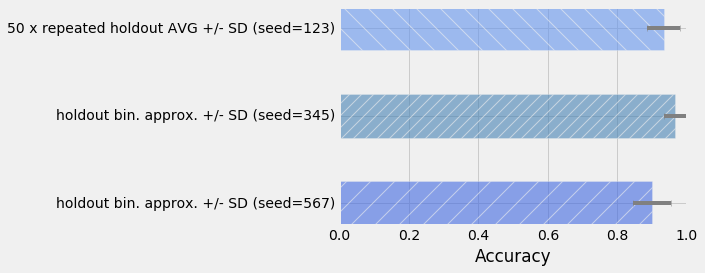

In [6]:
means = [y_pred_1_acc, y_pred_2_acc, pred2_mean]
ci = [y_pred_1_std, y_pred_2_std, pred2_std]
colors = ['royalblue', 'steelblue', 'cornflowerblue']
hatches = ['/', '//', '\\']
labels = ['holdout bin. approx. +/- SD (seed=567)',
          'holdout bin. approx. +/- SD (seed=345)',
          '50 x repeated holdout AVG +/- SD (seed=123)']


with plt.style.context(('fivethirtyeight')):
    fig, ax = plt.subplots(figsize=(10, 4))
    for i, c in enumerate(colors):
        rects1 = ax.barh(bottom=[i+1], 
                         width=[means[i]], 
                         height=0.5,
                         alpha=0.6,
                         ecolor='gray',
                         color=c,
                         hatch=hatches[i],
                         xerr=ci[i])

    #ax.get_xaxis().set_ticks([])
    ax.set_yticks(np.arange(1, len(labels)+1) + 0.25)
    ax.set_yticklabels(labels)
    plt.xlim([0.0, 1.0])
    ax.set_xlabel('Accuracy')
    #ax.legend(loc='upper center', ncol=1)
    #plt.savefig('./iris_comp_ci_small_1_1.svg')
    #ax.legend(loc='upper center', bbox_to_anchor=(1.4, 0.8), ncol=1) 
    #plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.tight_layout()
    plt.savefig('figures/model-eval-iris_1.svg')
    plt.show()

## K-fold and standard deviation

In [7]:
from sklearn.cross_validation import StratifiedKFold

cv = StratifiedKFold(y=y, n_folds=2, shuffle=False, random_state=123)
all_acc = []
for train_index, test_index in cv:
    pred = lr1.fit(X[train_index], y[train_index])\
           .predict(X[test_index])
    acc = np.mean(y[test_index] == pred)
    all_acc.append(acc)
    
all_acc = np.array(all_acc)
y_pred_cv2_mean = all_acc.mean()
y_pred_cv2_std = all_acc.std()

print(y_pred_cv2_mean, y_pred_cv2_std)

0.92 0.02


In [8]:
cv = StratifiedKFold(y=y, n_folds=10, shuffle=False, random_state=123)
all_acc = []
for train_index, test_index in cv:
    pred = lr1.fit(X[train_index], y[train_index])\
           .predict(X[test_index])
    acc = np.mean(y[test_index] == pred)
    all_acc.append(acc)
    
all_acc = np.array(all_acc)
y_pred_cv10_mean = all_acc.mean()
y_pred_cv10_std = all_acc.std()

print(y_pred_cv10_mean, y_pred_cv10_std)

0.93 0.0640312423743


In [9]:
cv = StratifiedKFold(y=y, n_folds=30, shuffle=False, random_state=123)
all_acc = []
for train_index, test_index in cv:
    pred = lr1.fit(X[train_index], y[train_index])\
           .predict(X[test_index])
    acc = np.mean(y[test_index] == pred)
    all_acc.append(acc)
    
all_acc = np.array(all_acc)
y_pred_cv30_mean = all_acc.mean()
y_pred_cv30_std = all_acc.std()

print(y_pred_cv30_mean, y_pred_cv30_std)

0.941666666667 0.123883906228


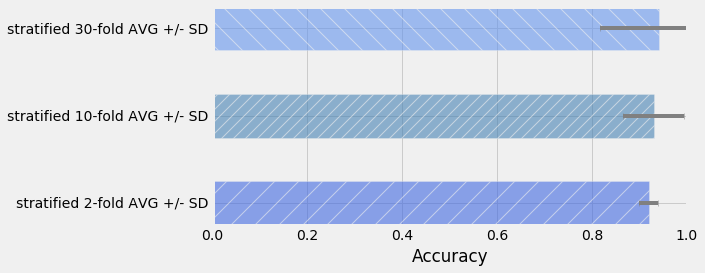

In [10]:
means = [y_pred_cv2_mean, y_pred_cv10_mean, y_pred_cv30_mean]
ci = [y_pred_cv2_std, y_pred_cv10_std, y_pred_cv30_std]
colors = ['royalblue', 'steelblue', 'cornflowerblue']
hatches = ['/', '//', '\\', '////']
labels = ['stratified 2-fold AVG +/- SD',
          'stratified 10-fold AVG +/- SD',
          'stratified 30-fold AVG +/- SD']


with plt.style.context(('fivethirtyeight')):
    fig, ax = plt.subplots(figsize=(10, 4))
    for i, c in enumerate(colors):
        rects1 = ax.barh(bottom=[i+1], 
                         width=[means[i]], 
                         height=0.5,
                         alpha=0.6,
                         ecolor='gray',
                         color=c,
                         hatch=hatches[i],
                         xerr=ci[i])

    #ax.get_xaxis().set_ticks([])
    ax.set_yticks(np.arange(1, len(labels)+1) + 0.25)
    ax.set_yticklabels(labels)
    plt.xlim([0.0, 1.0])
    ax.set_xlabel('Accuracy')
    #ax.legend(loc='upper center', ncol=1)
    #plt.savefig('./iris_comp_ci_small_1_1.svg')
    #ax.legend(loc='upper center', bbox_to_anchor=(1.4, 0.8), ncol=1) 
    #plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.tight_layout()
    plt.savefig('figures/model-eval-iris_2.svg')
    plt.show()

## Repeated k-fold

In [11]:
rng = np.random.RandomState(seed=1)
seeds = np.arange(10**6)
rng.shuffle(seeds)
seeds = seeds[:50]

repeated_cv = []

for i in seeds:
    cv = StratifiedKFold(y=y, n_folds=5, shuffle=True, random_state=i)
    all_acc = []
    for train_index, test_index in cv:
        pred = lr1.fit(X[train_index], y[train_index])\
               .predict(X[test_index])
        acc = np.mean(y[test_index] == pred)
        all_acc.append(acc)
    all_acc = np.array(all_acc)
    y_pred_cv10_mean = all_acc.mean()
    repeated_cv.append(y_pred_cv10_mean)

repeated_cv = np.array(repeated_cv)
repeated_cv_mean = repeated_cv.mean()
repeated_cv_std = repeated_cv.std()

print(repeated_cv_mean, repeated_cv_std)

0.9298 0.00882949602186


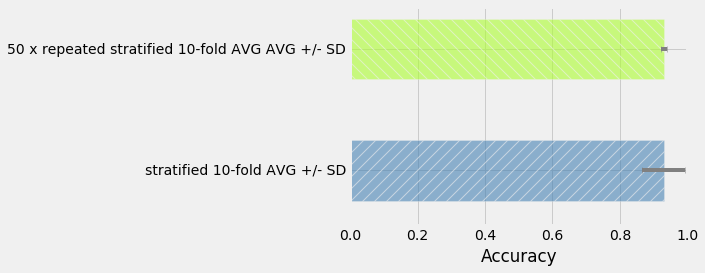

In [12]:
means = [y_pred_cv10_mean, repeated_cv_mean]
ci = [y_pred_cv10_std, repeated_cv_std]
colors = ['steelblue', 'greenyellow']
hatches = ['//', '\\\\']
labels = ['stratified 10-fold AVG +/- SD',
          '50 x repeated stratified 10-fold AVG AVG +/- SD']


with plt.style.context(('fivethirtyeight')):
    fig, ax = plt.subplots(figsize=(10, 4))
    for i, c in enumerate(colors):
        rects1 = ax.barh(bottom=[i+1], 
                         width=[means[i]], 
                         height=0.5,
                         alpha=0.6,
                         ecolor='gray',
                         color=c,
                         hatch=hatches[i],
                         xerr=ci[i])

    #ax.get_xaxis().set_ticks([])
    ax.set_yticks(np.arange(1, len(labels)+1) + 0.25)
    ax.set_yticklabels(labels)
    plt.xlim([0.0, 1.0])
    ax.set_xlabel('Accuracy')
    #ax.legend(loc='upper center', ncol=1)
    #plt.savefig('./iris_comp_ci_small_1_1.svg')
    #ax.legend(loc='upper center', bbox_to_anchor=(1.4, 0.8), ncol=1) 
    #plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.tight_layout()
    plt.savefig('figures/model-eval-iris_3.svg')
    plt.show()

## The "one-standard error" method

In [13]:
from sklearn.svm import SVC

clf = SVC(C=1.0, 
      kernel='rbf', 
      degree=3, 
      gamma=0.1,
      coef0=0.0, 
      shrinking=True, 
      probability=False, 
      tol=0.001, 
      cache_size=200, 
      class_weight=None, 
      verbose=False, 
      max_iter=-1, 
      decision_function_shape=None, 
      random_state=1)


params = list(10**i for i in np.arange(-4, 8))

cv_acc, cv_std, cv_stderr = [], [], []

for p in params:
    
    clf.C = p

    cv = StratifiedKFold(y=y, n_folds=10, shuffle=False, random_state=123)
    all_acc = []
    for train_index, test_index in cv:
        pred = clf.fit(X[train_index], y[train_index])\
               .predict(X[test_index])
        acc = np.mean(y[test_index] == pred)
        all_acc.append(acc)

    all_acc = np.array(all_acc)
    y_pred_cv10_mean = all_acc.mean()
    y_pred_cv10_std = all_acc.std()
    y_pred_cv10_stderr = y_pred_cv10_std / np.sqrt(10)

    cv_acc.append(y_pred_cv10_mean) 
    cv_std.append(y_pred_cv10_std)
    cv_stderr.append(y_pred_cv10_stderr)

In [14]:
best_idx = np.argmax(cv_acc)
min_idx = 999
for idx, scr in enumerate(cv_acc):
    if scr >= (cv_acc[best_idx] - cv_stderr[best_idx]):
        if idx < min_idx:
            min_idx = idx
        print(idx, scr, cv_stderr[idx])
print(min_idx)

0 0.92 0.018973665961
1 0.92 0.018973665961
2 0.92 0.018973665961
5 0.93 0.0202484567313
6 0.92 0.0275680975042
7 0.94 0.0209761769634
8 0.92 0.0275680975042
0


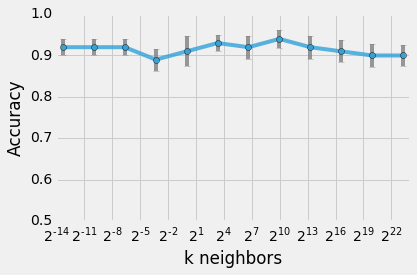

In [15]:
with plt.style.context(('fivethirtyeight')):

    fig, ax = plt.subplots()
    ax.errorbar(params, 
                cv_acc, 
                yerr=cv_stderr, 
                ecolor='gray', 
                marker='o', 
                alpha=0.8)
    ax.set_xscale('log', basex=2)
    plt.ylim([0.5, 1.0])
    ax.set_xlabel('k neighbors')
    ax.set_ylabel('Accuracy')
    
    plt.tight_layout()
    plt.savefig('figures/model-eval-iris_4.svg')
    plt.show()

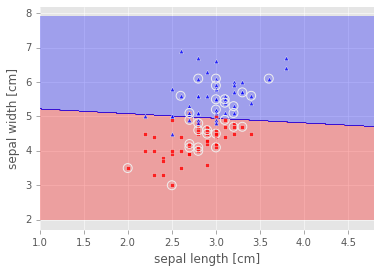

In [16]:
from mlxtend.evaluate import plot_decision_regions

clf.C=params[min_idx]

clf.fit(X_train, y_train)

with plt.style.context(('ggplot')):
    plot_decision_regions(X=X, y=y, clf=clf, X_highlight=X_test, legend=None, res=0.002)
    #plt.xlim([4.5, 8])
    #plt.ylim([1.5, 4])
    plt.xlabel('sepal length [cm]')
    plt.ylabel('sepal width [cm]')
    plt.savefig('figures/model-eval-iris_5.svg')
    plt.show()

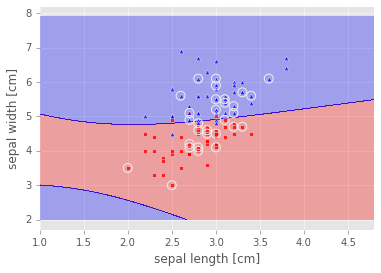

In [17]:
clf.C=params[best_idx]

clf.fit(X_train, y_train)

with plt.style.context(('ggplot')):
    plot_decision_regions(X=X, y=y, clf=clf, X_highlight=X_test, legend=None, res=0.002)
    #plt.xlim([4.5, 8])
    #plt.ylim([1.5, 4])
    plt.xlabel('sepal length [cm]')
    plt.ylabel('sepal width [cm]')
    plt.savefig('figures/model-eval-iris_6.svg')
    plt.show()

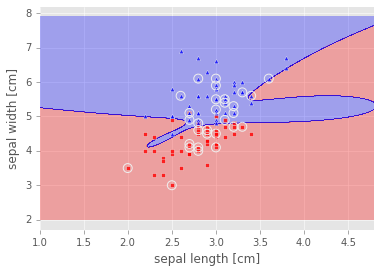

In [18]:
clf.C=params[-1]

clf.fit(X_train, y_train)

with plt.style.context(('ggplot')):
    plot_decision_regions(X=X, y=y, clf=clf, X_highlight=X_test, legend=None, res=0.002)
    #plt.xlim([4.5, 8])
    #plt.ylim([1.5, 4])
    plt.xlabel('sepal length [cm]')
    plt.ylabel('sepal width [cm]')
    plt.savefig('figures/model-eval-iris_7.svg')
    plt.show()